In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/632 [..............................] - ETA: 12:28 - loss: 0.1718 - STD: 1.5817e-04 - MAE: 0.4019

 10/632 [..............................] - ETA: 3s - loss: 0.0386 - STD: 1.4794e-04 - MAE: 0.1507   

 18/632 [..............................] - ETA: 3s - loss: 0.0328 - STD: 8.7781e-05 - MAE: 0.1404

 26/632 [>.............................] - ETA: 3s - loss: 0.0269 - STD: 7.2840e-05 - MAE: 0.1238

 35/632 [>.............................] - ETA: 3s - loss: 0.0230 - STD: 6.2941e-05 - MAE: 0.1154

 44/632 [=>............................] - ETA: 3s - loss: 0.0204 - STD: 5.2590e-05 - MAE: 0.1076

 53/632 [=>............................] - ETA: 3s - loss: 0.0187 - STD: 4.5718e-05 - MAE: 0.1025

 62/632 [=>............................] - ETA: 3s - loss: 0.0174 - STD: 4.1177e-05 - MAE: 0.0993

 70/632 [==>...........................] - ETA: 3s - loss: 0.0166 - STD: 3.8142e-05 - MAE: 0.0967

 79/632 [==>...........................] - ETA: 3s - loss: 0.0158 - STD: 3.5708e-05 - MAE: 0.0946

 88/632 [===>..........................] - ETA: 3s - loss: 0.0152 - STD: 3.4053e-05 - MAE: 0.0928

 97/632 [===>..........................] - ETA: 3s - loss: 0.0147 - STD: 3.3014e-05 - MAE: 0.0915

106/632 [====>.........................] - ETA: 3s - loss: 0.0143 - STD: 3.2508e-05 - MAE: 0.0904

114/632 [====>.........................] - ETA: 3s - loss: 0.0140 - STD: 3.2369e-05 - MAE: 0.0895

123/632 [====>.........................] - ETA: 3s - loss: 0.0137 - STD: 3.2632e-05 - MAE: 0.0887

132/632 [=====>........................] - ETA: 3s - loss: 0.0135 - STD: 3.3273e-05 - MAE: 0.0880

141/632 [=====>........................] - ETA: 3s - loss: 0.0132 - STD: 3.4350e-05 - MAE: 0.0873

150/632 [======>.......................] - ETA: 4s - loss: 0.0131 - STD: 3.5821e-05 - MAE: 0.0867

161/632 [======>.......................] - ETA: 4s - loss: 0.0128 - STD: 3.8279e-05 - MAE: 0.0861

170/632 [=======>......................] - ETA: 4s - loss: 0.0127 - STD: 4.0962e-05 - MAE: 0.0857

179/632 [=======>......................] - ETA: 4s - loss: 0.0125 - STD: 4.4359e-05 - MAE: 0.0853

187/632 [=======>......................] - ETA: 4s - loss: 0.0124 - STD: 4.8052e-05 - MAE: 0.0849

195/632 [========>.....................] - ETA: 3s - loss: 0.0123 - STD: 5.2680e-05 - MAE: 0.0846

204/632 [========>.....................] - ETA: 3s - loss: 0.0122 - STD: 5.9050e-05 - MAE: 0.0843

213/632 [=========>....................] - ETA: 3s - loss: 0.0121 - STD: 6.7600e-05 - MAE: 0.0841

221/632 [=========>....................] - ETA: 3s - loss: 0.0120 - STD: 7.7408e-05 - MAE: 0.0839

229/632 [=========>....................] - ETA: 3s - loss: 0.0120 - STD: 9.0540e-05 - MAE: 0.0837

237/632 [==========>...................] - ETA: 3s - loss: 0.0119 - STD: 1.0790e-04 - MAE: 0.0835

245/632 [==========>...................] - ETA: 3s - loss: 0.0118 - STD: 1.3168e-04 - MAE: 0.0833

253/632 [===========>..................] - ETA: 3s - loss: 0.0118 - STD: 1.6449e-04 - MAE: 0.0831

262/632 [===========>..................] - ETA: 3s - loss: 0.0117 - STD: 2.1824e-04 - MAE: 0.0829

271/632 [===========>..................] - ETA: 2s - loss: 0.0116 - STD: 3.0079e-04 - MAE: 0.0828

279/632 [============>.................] - ETA: 2s - loss: 0.0116 - STD: 4.1006e-04 - MAE: 0.0826

287/632 [============>.................] - ETA: 2s - loss: 0.0115 - STD: 5.6922e-04 - MAE: 0.0824

296/632 [=============>................] - ETA: 2s - loss: 0.0114 - STD: 8.4044e-04 - MAE: 0.0822

305/632 [=============>................] - ETA: 2s - loss: 0.0114 - STD: 0.0012 - MAE: 0.0820    

313/632 [=============>................] - ETA: 2s - loss: 0.0113 - STD: 0.0017 - MAE: 0.0817

322/632 [==============>...............] - ETA: 2s - loss: 0.0112 - STD: 0.0024 - MAE: 0.0814

331/632 [==============>...............] - ETA: 2s - loss: 0.0111 - STD: 0.0033 - MAE: 0.0810

340/632 [===============>..............] - ETA: 2s - loss: 0.0110 - STD: 0.0042 - MAE: 0.0807

349/632 [===============>..............] - ETA: 2s - loss: 0.0109 - STD: 0.0052 - MAE: 0.0803

358/632 [===============>..............] - ETA: 2s - loss: 0.0108 - STD: 0.0063 - MAE: 0.0799

367/632 [================>.............] - ETA: 2s - loss: 0.0107 - STD: 0.0074 - MAE: 0.0794

376/632 [================>.............] - ETA: 1s - loss: 0.0106 - STD: 0.0086 - MAE: 0.0789

385/632 [=================>............] - ETA: 1s - loss: 0.0105 - STD: 0.0097 - MAE: 0.0784

394/632 [=================>............] - ETA: 1s - loss: 0.0104 - STD: 0.0108 - MAE: 0.0779

403/632 [==================>...........] - ETA: 1s - loss: 0.0103 - STD: 0.0119 - MAE: 0.0775

412/632 [==================>...........] - ETA: 1s - loss: 0.0102 - STD: 0.0129 - MAE: 0.0771

421/632 [==================>...........] - ETA: 1s - loss: 0.0101 - STD: 0.0139 - MAE: 0.0766

430/632 [===================>..........] - ETA: 1s - loss: 0.0100 - STD: 0.0149 - MAE: 0.0763

439/632 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 0.0158 - MAE: 0.0759

448/632 [====================>.........] - ETA: 1s - loss: 0.0098 - STD: 0.0167 - MAE: 0.0755

457/632 [====================>.........] - ETA: 1s - loss: 0.0097 - STD: 0.0176 - MAE: 0.0751

466/632 [=====================>........] - ETA: 1s - loss: 0.0096 - STD: 0.0184 - MAE: 0.0748

474/632 [=====================>........] - ETA: 1s - loss: 0.0096 - STD: 0.0192 - MAE: 0.0745

483/632 [=====================>........] - ETA: 1s - loss: 0.0095 - STD: 0.0200 - MAE: 0.0741

491/632 [======================>.......] - ETA: 1s - loss: 0.0094 - STD: 0.0208 - MAE: 0.0738

500/632 [======================>.......] - ETA: 0s - loss: 0.0094 - STD: 0.0215 - MAE: 0.0735

509/632 [=======================>......] - ETA: 0s - loss: 0.0093 - STD: 0.0223 - MAE: 0.0732

518/632 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 0.0230 - MAE: 0.0729

527/632 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 0.0237 - MAE: 0.0726

536/632 [========================>.....] - ETA: 0s - loss: 0.0091 - STD: 0.0244 - MAE: 0.0723

545/632 [========================>.....] - ETA: 0s - loss: 0.0090 - STD: 0.0250 - MAE: 0.0721

554/632 [=========================>....] - ETA: 0s - loss: 0.0090 - STD: 0.0257 - MAE: 0.0718

563/632 [=========================>....] - ETA: 0s - loss: 0.0089 - STD: 0.0263 - MAE: 0.0715

572/632 [==========================>...] - ETA: 0s - loss: 0.0089 - STD: 0.0270 - MAE: 0.0712

581/632 [==========================>...] - ETA: 0s - loss: 0.0088 - STD: 0.0276 - MAE: 0.0710

590/632 [===========================>..] - ETA: 0s - loss: 0.0088 - STD: 0.0282 - MAE: 0.0707

599/632 [===========================>..] - ETA: 0s - loss: 0.0087 - STD: 0.0287 - MAE: 0.0705

608/632 [===========================>..] - ETA: 0s - loss: 0.0087 - STD: 0.0293 - MAE: 0.0703

617/632 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 0.0298 - MAE: 0.0700

626/632 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 0.0304 - MAE: 0.0698

632/632 [==============================] - 6s 8ms/step - loss: 0.0085 - STD: 0.0307 - MAE: 0.0697 - val_loss: 0.0044 - val_STD: 0.0488 - val_MAE: 0.0500


Epoch 2/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0532

  9/632 [..............................] - ETA: 4s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0550 

 17/632 [..............................] - ETA: 3s - loss: 0.0052 - STD: 0.0664 - MAE: 0.0543

 26/632 [>.............................] - ETA: 3s - loss: 0.0052 - STD: 0.0656 - MAE: 0.0545

 35/632 [>.............................] - ETA: 3s - loss: 0.0052 - STD: 0.0666 - MAE: 0.0541

 44/632 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0663 - MAE: 0.0541

 53/632 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0666 - MAE: 0.0540

 62/632 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0665 - MAE: 0.0541

 71/632 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0668 - MAE: 0.0539

 79/632 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0539

 87/632 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0671 - MAE: 0.0539

 95/632 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0538

104/632 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0537

112/632 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0674 - MAE: 0.0537

121/632 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0674 - MAE: 0.0538

130/632 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0538

139/632 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0674 - MAE: 0.0538

148/632 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0674 - MAE: 0.0538

157/632 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0538

166/632 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0538

175/632 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0538

184/632 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0674 - MAE: 0.0537

193/632 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0674 - MAE: 0.0536

201/632 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0536

209/632 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0536

218/632 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0677 - MAE: 0.0535

227/632 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0678 - MAE: 0.0535

236/632 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0678 - MAE: 0.0535

245/632 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0535

254/632 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0535

263/632 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0536

272/632 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0535

281/632 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0535

290/632 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0534

299/632 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0680 - MAE: 0.0534

308/632 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0681 - MAE: 0.0534

317/632 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0681 - MAE: 0.0533

326/632 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0682 - MAE: 0.0533

335/632 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0683 - MAE: 0.0532

344/632 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0532

353/632 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0531

362/632 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0531

371/632 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0530

380/632 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0530

389/632 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0530

398/632 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0529

407/632 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0529

416/632 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0529

425/632 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0528

434/632 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0528

443/632 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0527

452/632 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0527

461/632 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0527

470/632 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0526

479/632 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0526

488/632 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0526

497/632 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0526

506/632 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0525

515/632 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0525

524/632 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0525

533/632 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0525

542/632 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0525

551/632 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0524

560/632 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0524

569/632 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0524

578/632 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0524

587/632 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0523

596/632 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0523

605/632 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0523

614/632 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0523

623/632 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0523

631/632 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0522

632/632 [==============================] - 4s 6ms/step - loss: 0.0049 - STD: 0.0695 - MAE: 0.0522 - val_loss: 0.0041 - val_STD: 0.0495 - val_MAE: 0.0467


Epoch 3/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0054 - STD: 0.0641 - MAE: 0.0513

  9/632 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0505 

 17/632 [..............................] - ETA: 4s - loss: 0.0048 - STD: 0.0720 - MAE: 0.0512

 26/632 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0720 - MAE: 0.0506

 35/632 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0503

 44/632 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0502

 52/632 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0723 - MAE: 0.0501

 60/632 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0501

 69/632 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0500

 77/632 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0500

 86/632 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0499

 95/632 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0500

104/632 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

113/632 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0499

122/632 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0499

131/632 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498

140/632 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498

149/632 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0497

158/632 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0497

167/632 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0496

176/632 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0495

185/632 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0495

194/632 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0495

203/632 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0495

212/632 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0495

221/632 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0495

230/632 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0495

239/632 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0495

248/632 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494

257/632 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0495

266/632 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494

275/632 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0494

284/632 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0495

293/632 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0494

301/632 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0494

309/632 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0494

318/632 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0494

327/632 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0493

336/632 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0493

345/632 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0493

352/632 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0492

360/632 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0492

369/632 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0492

377/632 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0491

385/632 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491

393/632 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0492

402/632 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491

410/632 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491

418/632 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491

427/632 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491

435/632 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491

444/632 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0490

452/632 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0490

461/632 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0490

470/632 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0490

478/632 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0489

487/632 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0490

496/632 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0490

505/632 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0490

514/632 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0490

523/632 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0489

531/632 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0489

540/632 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0489

549/632 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0489

558/632 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0489

566/632 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0489

575/632 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0489

583/632 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0488

592/632 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0488

601/632 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0488

609/632 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0488

617/632 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0488

626/632 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0487

632/632 [==============================] - 4s 7ms/step - loss: 0.0043 - STD: 0.0736 - MAE: 0.0487 - val_loss: 0.0039 - val_STD: 0.0536 - val_MAE: 0.0452


Epoch 4/10000


  1/632 [..............................] - ETA: 16s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0474

  9/632 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0475 

 18/632 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0471

 25/632 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0475

 33/632 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0473

 41/632 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0473

 50/632 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0472

 59/632 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0473

 68/632 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0472

 77/632 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0472

 86/632 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

 95/632 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

104/632 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

113/632 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

122/632 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

131/632 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

140/632 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0474

149/632 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0474

157/632 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0474

166/632 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0474

175/632 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474

184/632 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

193/632 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

202/632 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

211/632 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

219/632 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

227/632 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0473

235/632 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0473

244/632 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0473

253/632 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0472

261/632 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472

270/632 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472

279/632 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

288/632 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0473

297/632 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0473

306/632 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0473

315/632 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

324/632 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0473

333/632 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0472

342/632 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472

350/632 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472

359/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

368/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

377/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0471

386/632 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0471

395/632 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0471

404/632 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0471

413/632 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0471

422/632 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0471

429/632 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

438/632 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

447/632 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

456/632 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

465/632 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

474/632 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

483/632 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

491/632 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

499/632 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

508/632 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

516/632 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

525/632 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

534/632 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

543/632 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

552/632 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

561/632 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

570/632 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0470

579/632 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0470

588/632 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0469

597/632 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0469

605/632 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0469

614/632 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0469

623/632 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0469

632/632 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0469

632/632 [==============================] - 4s 7ms/step - loss: 0.0041 - STD: 0.0756 - MAE: 0.0469 - val_loss: 0.0036 - val_STD: 0.0611 - val_MAE: 0.0444


Epoch 5/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

  9/632 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0464 

 18/632 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0787 - MAE: 0.0462

 26/632 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0457

 35/632 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0459

 44/632 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0462

 53/632 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0462

 61/632 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461

 69/632 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0460

 77/632 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0461

 86/632 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461

 94/632 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462

103/632 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462

112/632 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462

121/632 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

130/632 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

139/632 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

148/632 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

157/632 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

165/632 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0460

173/632 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

182/632 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

191/632 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

200/632 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

209/632 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

218/632 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

227/632 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

236/632 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

244/632 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

253/632 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

262/632 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

271/632 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

280/632 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

289/632 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

298/632 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

307/632 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

315/632 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

324/632 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

333/632 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

342/632 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

351/632 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

360/632 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

369/632 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

377/632 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

385/632 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

393/632 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

401/632 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

410/632 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

419/632 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

428/632 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

437/632 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

445/632 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

454/632 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

463/632 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

472/632 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

481/632 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

490/632 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

499/632 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

508/632 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

517/632 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

526/632 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

534/632 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

542/632 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

550/632 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

558/632 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

566/632 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

575/632 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

584/632 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

593/632 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

602/632 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

611/632 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

620/632 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

629/632 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

632/632 [==============================] - 4s 7ms/step - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457 - val_loss: 0.0035 - val_STD: 0.0614 - val_MAE: 0.0438


Epoch 6/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0040 - STD: 0.0798 - MAE: 0.0465

 10/632 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0453 

 19/632 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0449

 28/632 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

 37/632 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

 46/632 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

 55/632 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

 64/632 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

 73/632 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0448

 82/632 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0448

 91/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0448

100/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0447

109/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0447

118/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

127/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

136/632 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

145/632 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

154/632 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

163/632 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

172/632 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0449

181/632 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0449

190/632 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0449

199/632 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0449

208/632 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0449

215/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

224/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

233/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0449

242/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0449

251/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0449

260/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0449

269/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0449

278/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0449

287/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0449

296/632 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0449

305/632 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

314/632 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

323/632 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

332/632 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

341/632 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

350/632 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

359/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

368/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

377/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

386/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

395/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

402/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

411/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

420/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

429/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

438/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

447/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

456/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

465/632 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

474/632 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

483/632 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

492/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

501/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

508/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

517/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

526/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

535/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

544/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

553/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

562/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

571/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

580/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

589/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

598/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

607/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

616/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

625/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

632/632 [==============================] - 4s 6ms/step - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448 - val_loss: 0.0034 - val_STD: 0.0614 - val_MAE: 0.0424


Epoch 7/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0438

 10/632 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0434 

 19/632 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0439

 28/632 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

 37/632 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0440

 46/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0440

 54/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440

 63/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0439

 72/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0438

 81/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0437

 90/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

 99/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

108/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0439

117/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440

125/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0440

134/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0440

142/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0439

151/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0439

160/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0439

169/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0438

178/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

187/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

196/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

204/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

212/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0439

221/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

230/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

239/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

248/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

257/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

266/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

275/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

284/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

292/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

301/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

310/632 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

318/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

327/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0441

336/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

345/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

354/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

363/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

372/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

381/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

390/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

399/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

408/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

417/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

426/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

435/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

444/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

453/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

462/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

471/632 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0443

480/632 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0443

489/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

498/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

507/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

515/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

524/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

533/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

542/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

551/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

560/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

569/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

578/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

587/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

596/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0443

605/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0443

614/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0443

623/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0443

631/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443

632/632 [==============================] - 4s 6ms/step - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443 - val_loss: 0.0034 - val_STD: 0.0660 - val_MAE: 0.0425


Epoch 8/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0042 - STD: 0.0853 - MAE: 0.0439

 10/632 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0436 

 19/632 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0434

 28/632 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

 37/632 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0433

 46/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0431

 55/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

 64/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

 73/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

 82/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

 91/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

100/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433

109/632 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

118/632 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

127/632 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

136/632 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

145/632 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

154/632 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

163/632 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

172/632 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

181/632 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

190/632 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

199/632 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

208/632 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

217/632 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

225/632 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

234/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

243/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

252/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0435

261/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0436

270/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0436

278/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0437

286/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0437

295/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0437

304/632 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

313/632 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0437

322/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

331/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0437

340/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0437

349/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0437

358/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0437

367/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0437

375/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0437

384/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

393/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

402/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0437

411/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0437

420/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0437

429/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0437

438/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0437

447/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0437

456/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0437

465/632 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

474/632 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

483/632 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

492/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0436

501/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436

510/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0436

519/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

528/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

537/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

546/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0436

555/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0436

564/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0436

573/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

582/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

591/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

600/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

608/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

617/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

626/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

632/632 [==============================] - 4s 6ms/step - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437 - val_loss: 0.0034 - val_STD: 0.0630 - val_MAE: 0.0431


Epoch 9/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

 10/632 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0783 - MAE: 0.0436 

 18/632 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0431

 27/632 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0790 - MAE: 0.0428

 36/632 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0429

 45/632 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0431

 54/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

 63/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

 72/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

 81/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

 90/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

 99/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

108/632 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

117/632 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

126/632 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

135/632 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433

144/632 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

153/632 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

162/632 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

171/632 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

180/632 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

188/632 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

197/632 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

205/632 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

214/632 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

223/632 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

232/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

240/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

249/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

257/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

266/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

275/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

284/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

293/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

301/632 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

310/632 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

319/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

328/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

336/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

344/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

353/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

362/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

370/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

379/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

387/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

395/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

404/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

413/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

421/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

430/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

438/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

447/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

456/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

465/632 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

474/632 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

483/632 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

492/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

501/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

510/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

519/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

528/632 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

537/632 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

546/632 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

555/632 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

564/632 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

573/632 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

582/632 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

590/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

598/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

606/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

614/632 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

623/632 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

632/632 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

632/632 [==============================] - 4s 7ms/step - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431 - val_loss: 0.0036 - val_STD: 0.0616 - val_MAE: 0.0437


Epoch 10/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0439

  9/632 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0426 

 18/632 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0422

 26/632 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0426

 35/632 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0790 - MAE: 0.0427

 43/632 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0792 - MAE: 0.0426

 52/632 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0792 - MAE: 0.0427

 61/632 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0425

 70/632 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0425

 78/632 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

 87/632 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

 96/632 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

105/632 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0428

113/632 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

122/632 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0427

131/632 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0427

139/632 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0427

148/632 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0427

156/632 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0427

165/632 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0427

173/632 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

182/632 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0427

191/632 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

200/632 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

209/632 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

218/632 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

227/632 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0427

236/632 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0427

244/632 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0427

252/632 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0427

261/632 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0426

270/632 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0426

277/632 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0426

282/632 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0426

288/632 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0426

294/632 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0426

303/632 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0427

310/632 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0427

318/632 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0427

326/632 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0427

335/632 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0427

344/632 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0427

351/632 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0427

357/632 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0428

366/632 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0428

375/632 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0427

384/632 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0427

393/632 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0427

401/632 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0427

409/632 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0427

418/632 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0427

427/632 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0427

435/632 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0427

443/632 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0427

451/632 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0427

459/632 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0426

467/632 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0426

475/632 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0426

483/632 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426

491/632 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426

499/632 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426

507/632 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426

515/632 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426

523/632 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426

531/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426

539/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426

547/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426

554/632 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426

563/632 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426

572/632 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426

580/632 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426

589/632 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426

598/632 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426

607/632 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426

615/632 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426

624/632 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426

632/632 [==============================] - 4s 7ms/step - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426 - val_loss: 0.0039 - val_STD: 0.0584 - val_MAE: 0.0443


Epoch 11/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0035 - STD: 0.0767 - MAE: 0.0426

  9/632 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421 

 17/632 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0424

 26/632 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0427

 33/632 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0792 - MAE: 0.0427

 41/632 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0425

 50/632 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0796 - MAE: 0.0423

 59/632 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0422

 67/632 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0421

 73/632 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0422

 81/632 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0423

 90/632 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0423

 99/632 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0422

108/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0422

117/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0422

126/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0422

135/632 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0422

144/632 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0422

153/632 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0424

162/632 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0425

171/632 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0425

180/632 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0425

189/632 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0425

198/632 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0425

207/632 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0424

216/632 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0424

225/632 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0424

232/632 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0424

240/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0424

248/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0423

255/632 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0424

263/632 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0425

271/632 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0425

279/632 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0425

287/632 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0425

295/632 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0425

303/632 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0425

312/632 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0425

321/632 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0425

330/632 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0424

339/632 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0424

347/632 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0424

355/632 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0424

364/632 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0424

373/632 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0424

382/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0424

391/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0423

400/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0423

409/632 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0423

418/632 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0423

427/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0423

436/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0423

445/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0423

454/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0423

463/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0423

472/632 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0423

481/632 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0423

490/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0423

499/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0423

508/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0423

517/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0422

526/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0422

535/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0422

544/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0422

553/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0423

563/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0423

572/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0423

581/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0423

589/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0423

598/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0423

607/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0423

616/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0422

625/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0422

632/632 [==============================] - 4s 7ms/step - loss: 0.0033 - STD: 0.0805 - MAE: 0.0423 - val_loss: 0.0045 - val_STD: 0.0566 - val_MAE: 0.0478


Epoch 12/10000


  1/632 [..............................] - ETA: 18s - loss: 0.0040 - STD: 0.0724 - MAE: 0.0454

  9/632 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0789 - MAE: 0.0431 

 18/632 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0430

 27/632 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0431

 36/632 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0431

 45/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0431

 54/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

 63/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

 72/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0431

 81/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0430

 90/632 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0428

 99/632 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

108/632 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0427

117/632 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0425

126/632 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0424

135/632 [=====>........................] - ETA: 2s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0424

144/632 [=====>........................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0425

153/632 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0426

162/632 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0427

171/632 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0428

180/632 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

189/632 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

198/632 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0427

207/632 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0427

216/632 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0426

225/632 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426

234/632 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0425

243/632 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0425

252/632 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0425

261/632 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0425

270/632 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0424

279/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0424

289/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0424

298/632 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0423

307/632 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0423

316/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0423

325/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0423

334/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0422

343/632 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0422

352/632 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0422

361/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0422

370/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0422

379/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0422

388/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0422

397/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0422

406/632 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0422

415/632 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0422

424/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0422

433/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0422

442/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0421

451/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0421

460/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0422

469/632 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0421

478/632 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0421

487/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0421

496/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0421

505/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0421

514/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0421

523/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0421

532/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0421

541/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0421

550/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0421

559/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0421

568/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0421

577/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0421

586/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0420

595/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0420

604/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0420

613/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0420

622/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0420

631/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0420

632/632 [==============================] - 4s 6ms/step - loss: 0.0033 - STD: 0.0807 - MAE: 0.0420 - val_loss: 0.0035 - val_STD: 0.0637 - val_MAE: 0.0432


Epoch 13/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

 10/632 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0808 - MAE: 0.0411 

 19/632 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0414

 28/632 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0416

 37/632 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0415

 46/632 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0416

 55/632 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0415

 64/632 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0415

 73/632 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0818 - MAE: 0.0414

 82/632 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0415

 91/632 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0415

100/632 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0414

109/632 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0414

118/632 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0413

127/632 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0413

136/632 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0413

145/632 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.0817 - MAE: 0.0413

154/632 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0818 - MAE: 0.0413

163/632 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0818 - MAE: 0.0413

172/632 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0413

181/632 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0817 - MAE: 0.0413

190/632 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0817 - MAE: 0.0414

199/632 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0413

208/632 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0413

217/632 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0413

226/632 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0413

235/632 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0413

244/632 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0413

253/632 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0413

262/632 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0413

271/632 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0413

280/632 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0413

289/632 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0413

298/632 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0413

307/632 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0413

316/632 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0413

325/632 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0413

334/632 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0413

343/632 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0413

352/632 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0414

361/632 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0413

370/632 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0413

379/632 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0413

388/632 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0413

398/632 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0413

407/632 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0414

416/632 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0414

425/632 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0414

434/632 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0414

443/632 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0414

452/632 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0413

461/632 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0413

470/632 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0413

479/632 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0413

488/632 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0413

497/632 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0413

506/632 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0413

515/632 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0413

524/632 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0414

533/632 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0413

542/632 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0413

551/632 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0414

560/632 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0414

569/632 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0414

578/632 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0414

587/632 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0414

596/632 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0414

605/632 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0414

614/632 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0414

623/632 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0414

632/632 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0414

632/632 [==============================] - 4s 6ms/step - loss: 0.0032 - STD: 0.0814 - MAE: 0.0414 - val_loss: 0.0038 - val_STD: 0.0717 - val_MAE: 0.0450


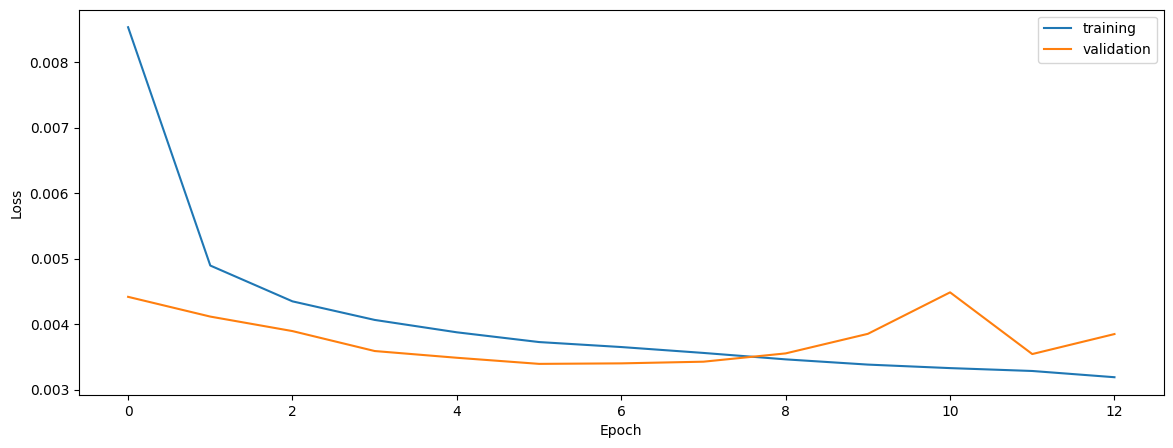

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.799316137452022
0.7999440827795006
0.7515121763527721


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.799316137452022
0.7999440827795006
0.7515121763527721


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.8024497197386696
0.8016109921468675
0.7635378859715888


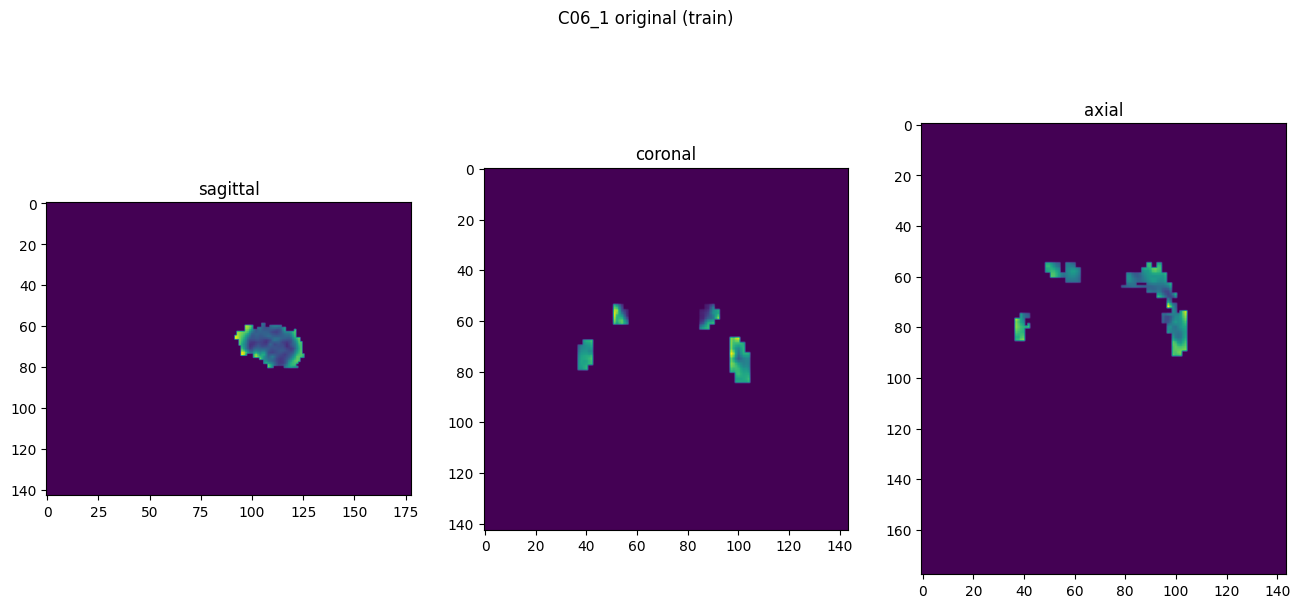

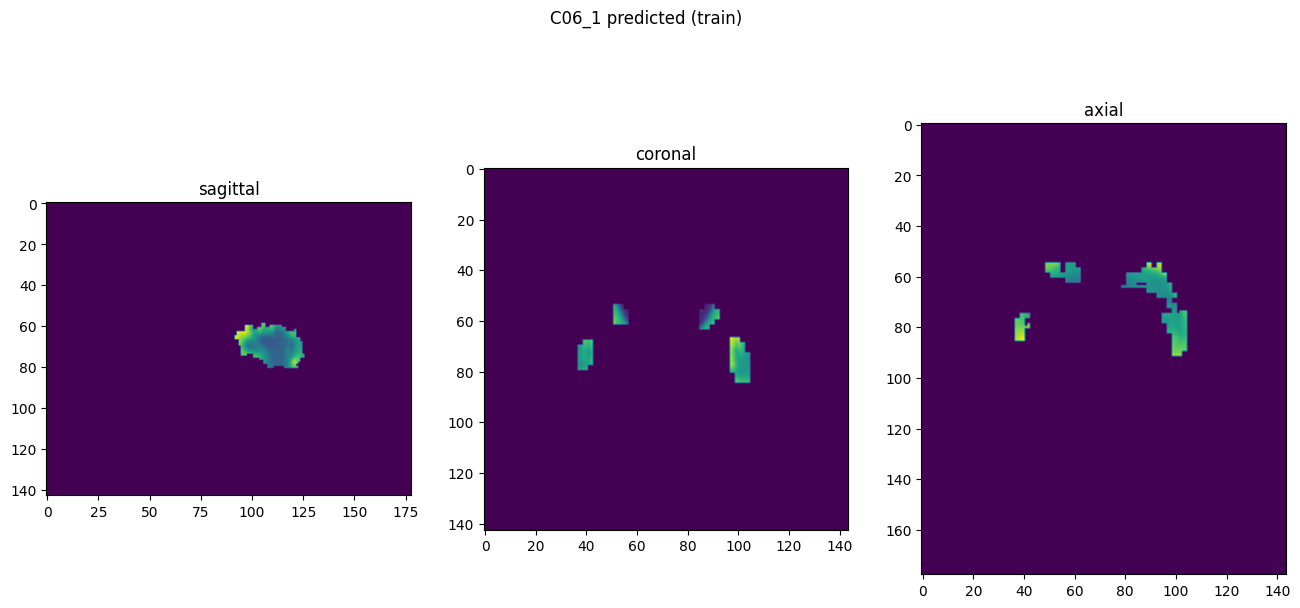

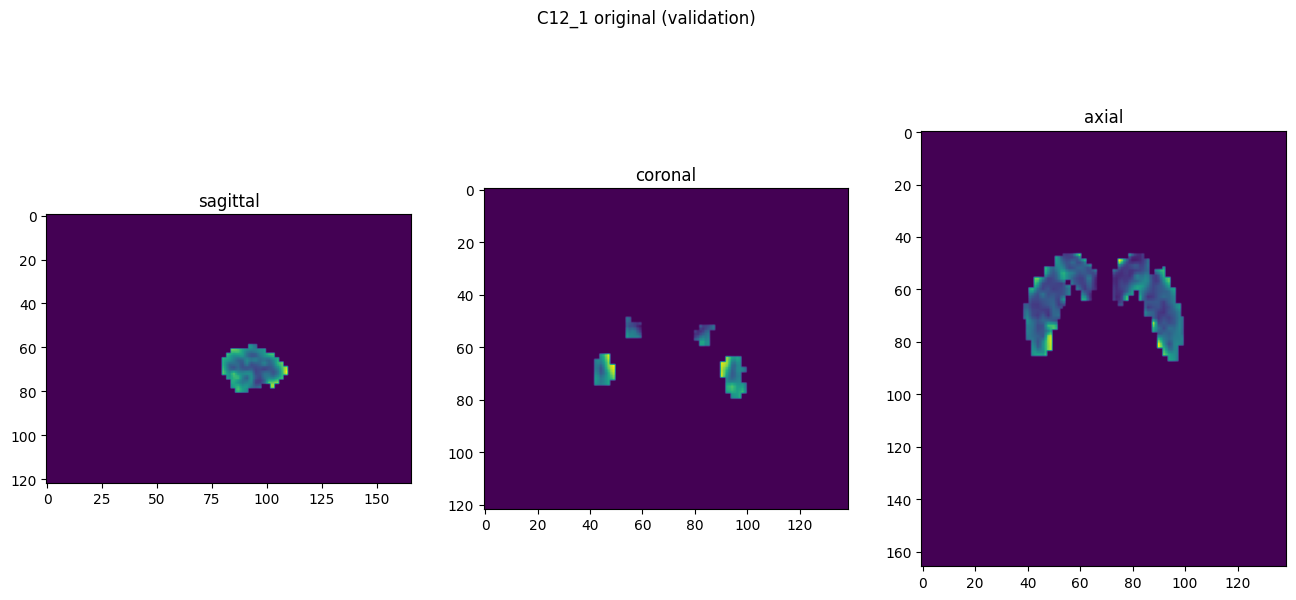

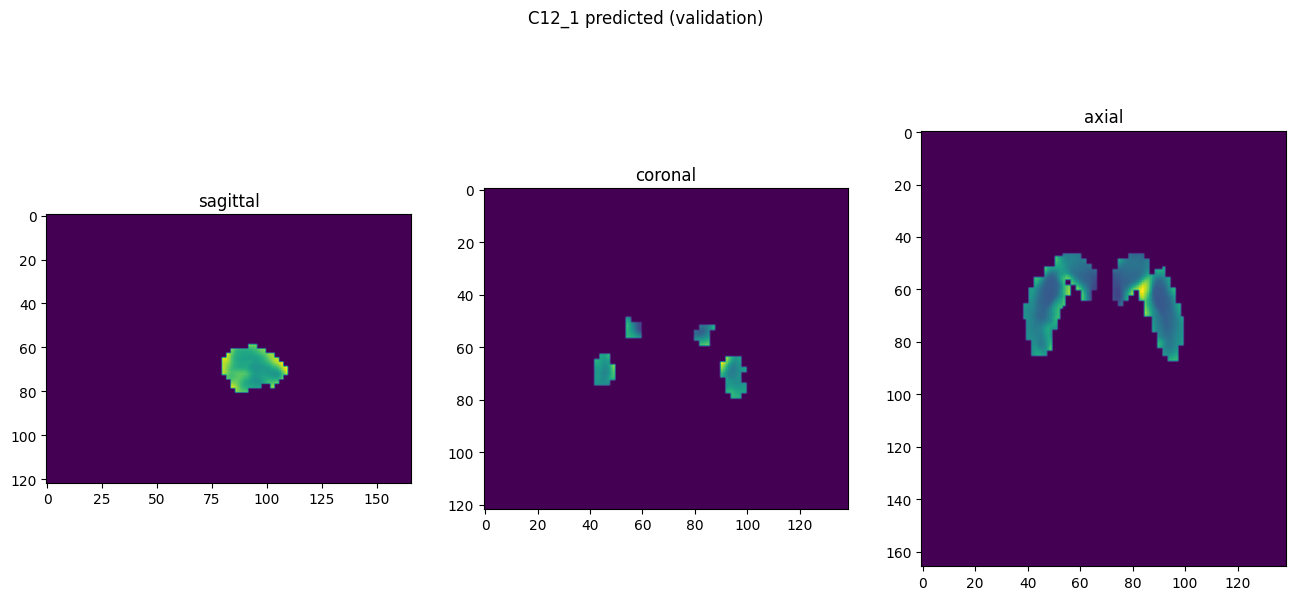

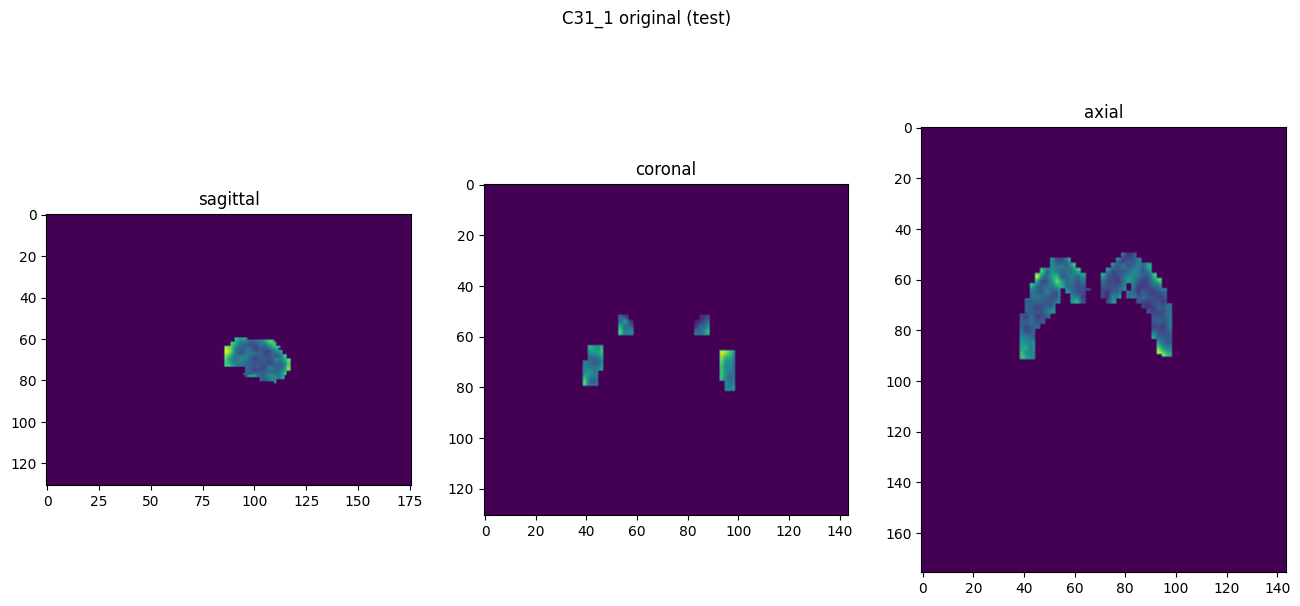

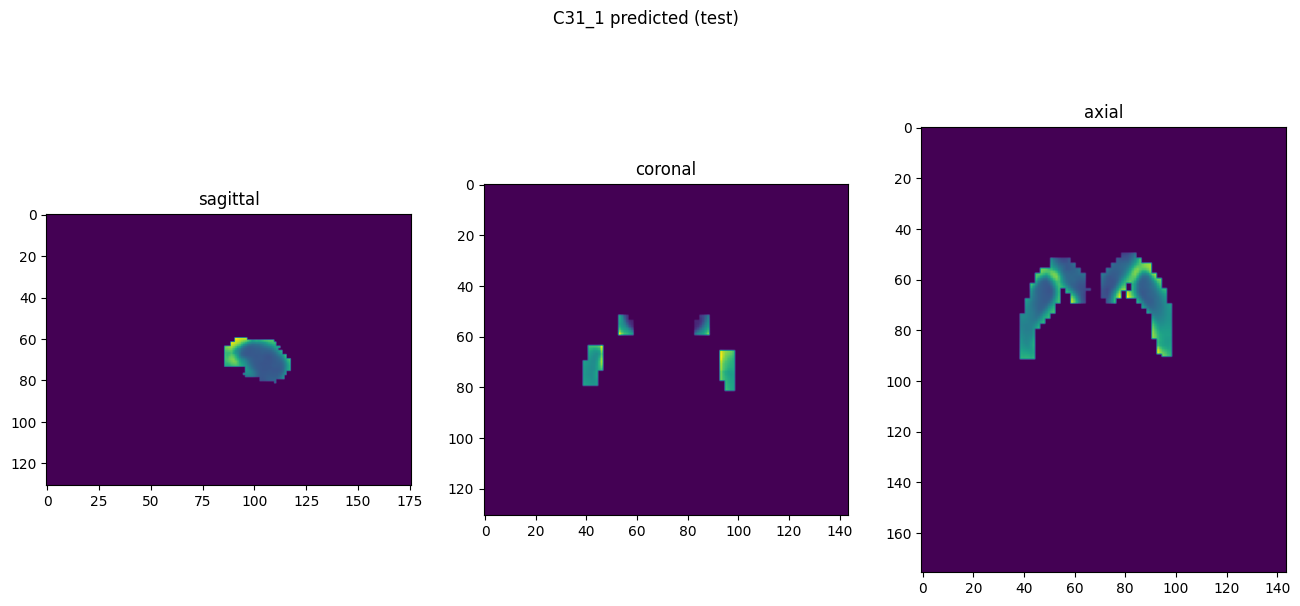

In [10]:
showResults(model, gen, threshold=None, background=False)